In [14]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [15]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [16]:
# load the data set
df = pd.read_csv('apr.csv', encoding='utf-8')
print("Number of Points",len(df)) 

Number of Points 21946


In [17]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['lat', 'lon'])

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 0.3 / kms_per_radian

In [18]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))
print(num_clusters)
# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
#print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
#print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

85


In [19]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [20]:
for i,x in enumerate(clusters):
    print("Number of Points in Cluster with id "+str(i)+' is ',len(x))
    if len(x) == 0:
        clusters.pop(i)


Number of Points in Cluster with id 0 is  8059
Number of Points in Cluster with id 1 is  4718
Number of Points in Cluster with id 2 is  21
Number of Points in Cluster with id 3 is  212
Number of Points in Cluster with id 4 is  117
Number of Points in Cluster with id 5 is  10
Number of Points in Cluster with id 6 is  36
Number of Points in Cluster with id 7 is  10
Number of Points in Cluster with id 8 is  10
Number of Points in Cluster with id 9 is  18
Number of Points in Cluster with id 10 is  656
Number of Points in Cluster with id 11 is  14
Number of Points in Cluster with id 12 is  39
Number of Points in Cluster with id 13 is  31
Number of Points in Cluster with id 14 is  62
Number of Points in Cluster with id 15 is  14
Number of Points in Cluster with id 16 is  22
Number of Points in Cluster with id 17 is  38
Number of Points in Cluster with id 18 is  176
Number of Points in Cluster with id 19 is  73
Number of Points in Cluster with id 20 is  10
Number of Points in Cluster with id 

In [21]:
def get_centermost_point(cluster):
    try:
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)
    except:
        print('HIJ')
    
centermost_points = clusters.map(get_centermost_point)

In [27]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
print('Coordinates of Centers')
print (rep_points)
rep_points.to_csv('centers.csv')
    


Coordinates of Centers
       lat     lon
0   40.694 -73.946
1   40.770 -73.973
2   40.669 -73.800
3   40.887 -73.906
4   40.860 -73.893
5   40.874 -73.887
6   40.670 -73.871
7   40.612 -74.010
8   40.670 -73.883
9   40.701 -73.808
10  40.734 -74.038
11  40.683 -73.806
12  40.724 -74.072
13  40.725 -73.790
14  40.733 -74.060
15  40.711 -73.851
16  40.794 -73.921
17  40.724 -73.906
18  40.823 -73.924
19  40.765 -74.026
20  40.615 -73.928
21  40.626 -73.920
22  40.692 -74.181
23  40.617 -73.943
24  40.646 -73.786
25  40.760 -73.828
26  40.578 -73.967
27  40.757 -73.849
28  40.764 -73.872
29  40.727 -73.820
..     ...     ...
54  40.621 -73.931
55  40.787 -74.044
56  40.718 -73.803
57  40.787 -73.837
58  40.623 -74.013
59  40.740 -73.614
60  40.858 -73.867
61  40.775 -74.017
62  40.636 -73.914
63  41.032 -73.769
64  40.680 -73.844
65  40.680 -73.862
66  40.621 -74.006
67  40.576 -73.981
68  40.858 -73.906
69  40.714 -73.786
70  40.763 -73.815
71  40.738 -73.906
72  40.585 -73.949
73  40.5

In [28]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
rs.to_csv('closest-points-to-centers.csv', encoding='utf-8')
print(rs)

       lat     lon  count
0   40.694 -73.946   15.0
1   40.770 -73.973    1.0
2   40.669 -73.800    2.0
3   40.887 -73.906    1.0
4   40.860 -73.893    2.0
5   40.874 -73.887    1.0
6   40.670 -73.871    1.0
7   40.612 -74.010   11.0
8   40.670 -73.883    9.0
9   40.701 -73.808    4.0
10  40.734 -74.038    1.0
11  40.683 -73.806    2.0
12  40.724 -74.072    3.0
13  40.725 -73.790    1.0
14  40.733 -74.060    1.0
15  40.711 -73.851    1.0
16  40.794 -73.921    3.0
17  40.724 -73.906    1.0
18  40.823 -73.924    1.0
19  40.765 -74.026    1.0
20  40.615 -73.928    1.0
21  40.626 -73.920    2.0
22  40.692 -74.181   20.0
23  40.617 -73.943    1.0
24  40.646 -73.786    5.0
25  40.760 -73.828    4.0
26  40.578 -73.967    1.0
27  40.757 -73.849    5.0
28  40.764 -73.872    2.0
29  40.727 -73.820    1.0
..     ...     ...    ...
54  40.621 -73.931    1.0
55  40.787 -74.044    1.0
56  40.718 -73.803    1.0
57  40.787 -73.837    2.0
58  40.623 -74.013    1.0
59  40.740 -73.614    2.0
60  40.858 -

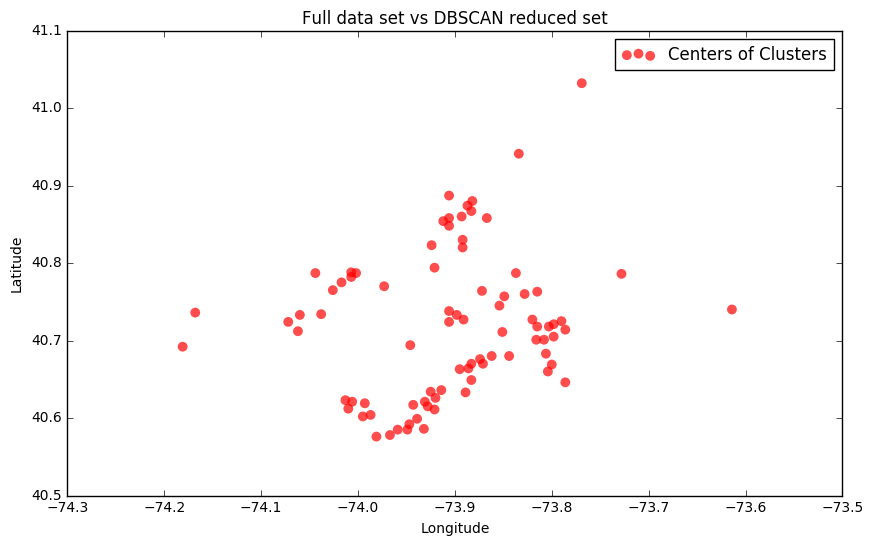

In [32]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
#df_scatter = ax.scatter(df['lon'], df['lat'], c='w', alpha=0.9, s=3)
rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='r', edgecolor='None', alpha=0.7, s=50)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([rs_scatter], ['Centers of Clusters'], loc='upper right')
plt.show()